## Henon Heiles: Reversible Polynomial Henon Maps

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb
import os
import sys
import random as rd

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import HenonHeiles_Methods as hh

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

### Energy

In [2]:
E = 0.1
Ename = "01"

### Import Training Dataset

In [3]:
x, y = hh.read_dataset('x_train_'+ Ename +'.txt', 'y_train_'+ Ename +'.txt')

Number of points:  15740


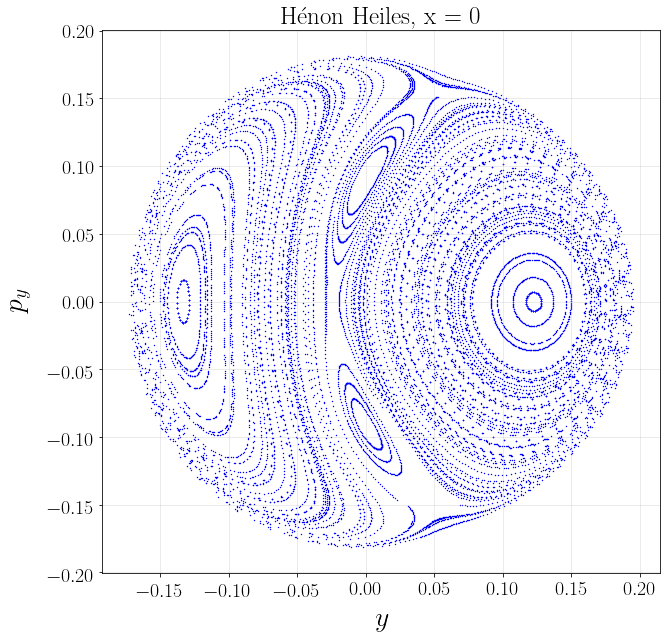

In [4]:
hh.plot_dataset(x)

### Training Dataset

In [11]:
train_dataset, val_dataset = hh.train_dataset(x, y, 1000, 1000, 1000)

### Model

In [84]:
class weight(tf.keras.layers.Layer):

    def __init__(self, num_outputs):
        super(weight, self).__init__()
        self.num_outputs = num_outputs


    def build(self, input_shape):
        self.w = self.add_weight("w",
                          shape=[int(input_shape[-1]),
                                 self.num_outputs])
        
    def call(self, inputs, inverse):
        if inverse == "direct":
        return tf.matmul(inputs, self.w)

layer_weights = weight(5)

In [85]:
t = layer_weights(tf.constant([[1.,1.,1.],[2.,3.,4.], [1.,1.,3.]]))
t

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.32881594, -0.8525262 ,  0.37074924, -0.8229172 ,  1.3239155 ],
       [ 1.6356387 , -3.3436809 ,  1.7445533 , -1.9794497 ,  4.295619  ],
       [ 1.8410118 , -1.6298162 ,  1.4219403 , -0.4774853 ,  2.7859912 ]],
      dtype=float32)>

In [95]:
class bias(tf.keras.layers.Layer):

    def __init__(self, num_outputs):
        super(bias, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.b = self.add_weight("b",
                          shape=[int(input_shape[-2]),
                                 self.num_outputs])
        
    def call(self, inputs, inverse):
        if inverse == "direct":
            return inputs + self.b
        
        if inverse == "inverse":
            return inputs - self.b

layer_bias = bias(5)

In [101]:
layer_bias(layer_bias(tf.ones([15,5]), "inverse"), "direct")

<tf.Tensor: shape=(15, 5), dtype=float32, numpy=
array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.99999994, 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.99999994, 1.        , 0.99999994, 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 0.99999994, 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.99999994, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        

## Decaying Learning Rate

In [13]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Checkpoints

In [14]:
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [15]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.0005), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [16]:
#wandb.init()
start_time = time.time()
history = model.fit(train_dataset, epochs = 100, validation_data=val_dataset, callbacks=[callback, cp_callback], verbose=1)
print("running time : %s seconds" % (time.time() - start_time))

Epoch 1/100


InternalError:  Blas xGEMMStridedBatched launch failed : a.shape=[1,2,2], b.shape=[1000,2,1], m=2, n=1, k=2, batch_size=1000
	 [[node henon_r/hr/MatVec/MatMul (defined at ..\AllMethods\ReversibleSymplecticNN.py:88) ]] [Op:__inference_train_function_74318]

Errors may have originated from an input operation.
Input Source operations connected to node henon_r/hr/MatVec/MatMul:
 henon_r/hr/concat/concat (defined at ..\AllMethods\ReversibleSymplecticNN.py:75)

Function call stack:
train_function


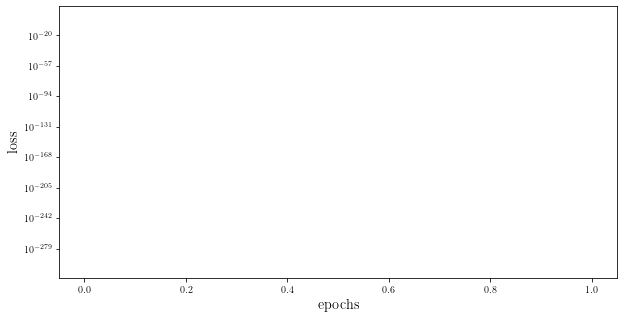

In [45]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.savefig("loss_Henon_E01667")

# Tests

In [ ]:
start_time = time.time()

#x0 = np.array([[0.025, 0.],[0.08, 0.],[0.085, 0.],[0.09, 0.],[0.095, 0.],[0.15, 0.],[0.1, -0.07],[0.1, -0.04],[0.1, 0.01],[0.1, 0.08],[0.1, 0.075]])
x0 = np.array([[rd.randrange(-100, 100, 1)*0.001,rd.randrange(-100, 100, 1)*0.001] for _ in range(10)])
iterations = [model(x0)]
for _ in range(200):
    iterations.append(model(iterations[-1]))

print("running time : %s seconds" % (time.time() - start_time))

In [ ]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 25)

for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0)
    
plt.scatter(*zip(*x0), s=15, linewidth=0)

#plt.scatter([i[0] for i in Poincare_points], [i[1] for i in Poincare_points], linewidth = 0, s=2)

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.show()

In [3]:
model(x)

NameError: name 'model' is not defined

In [ ]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Composition of H\'enon Maps', fontsize = 30)
plt.scatter(Ty,Tydot, color = "b", label = r'target, $x$', linewidth = 1, s=2)
plt.scatter(*zip(*test.numpy()), color = "r", label = r'$\mathcal{T}^{2}(x)$, learned', linewidth = 1, s=2)
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25, loc = 'lower right')
#plt.savefig("Iterations_Henon_E0125")
plt.show()